# Set Up

In [16]:
# Basic imports
import os
import random
import importlib
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Machine learning imports
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

# Financial imports
#import yfinance as yf
#import pandas_datareader as pdr

# Self Packages
import data
importlib.reload(data)
from data import load_data

# Setting random seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [17]:
load_data()

,Price,DXY,DFII10,VIX,CPI,Sentiment_Numeric,EMA30,EMA252,RSI
Date,,,,,,,,,
1998-01-01,290.2,NaN,NaN,NaN,161.600,NaN,NaN,NaN,NaN
1998-01-02,288.0,NaN,NaN,NaN,161.600,NaN,NaN,NaN,NaN
1998-01-05,284.4,NaN,NaN,NaN,161.600,NaN,NaN,NaN,NaN
1998-01-06,282.8,NaN,NaN,NaN,161.600,NaN,NaN,NaN,NaN
1998-01-07,281.6,NaN,NaN,NaN,161.600,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2024-12-25,2613.8,108.260002,2.24,14.27,315.493,0.0,2613.800735,2613.800735,43.738140
2024-12-26,2613.8,108.129997,2.23,14.73,315.493,0.0,2613.800073,2613.800073,44.348244
2024-12-27,2616.0,108.000000,2.28,15.95,315.493,0.0,2615.780007,2615.780007,34.074074


# Data Processing

## Helper Functions

In [27]:
def clean_CPI(cpi_csv):
    """
    Load and clean CPI data from a CSV file.

    Parameters:
        cpi_csv (str): Path to the CSV file containing CPI data
       
    Returns:
        DataFrame: Pandas DataFrame with loaded data
    """
    
    df = pd.read_csv(cpi_csv)

    # Function to combine Year and Period into Date
    def combine_year_period(row):
        if row['Period'].startswith('M'):
            month = int(row['Period'][1:])
            return pd.to_datetime(f"{row['Year']}-{month}-01")
        else:
            return None


    # Apply the function to create Date column
    df['Date'] = df.apply(combine_year_period, axis=1)

    # Drop rows with None values in Date column
    df = df.dropna(subset=['Date'])

    # Drop Year and Period columns
    df = df.drop(columns=['Year', 'Period', 'Series ID'])
    df.set_index('Date', inplace=True)
    return df

def load_sentiment_data(sentiment_csv):
    """
    Load and clean sentiment analysis data from a CSV file.

    Parameters:
        sentiment_csv (str): Path to the CSV file containing sentiment analysis data
       
    Returns:
        DataFrame: Pandas DataFrame with loaded data
    """
    df = pd.read_csv(sentiment_csv)
    def correct_date_format(date_str):
        parts = date_str.split('/')
        if len(parts) > 1:
            return pd.to_datetime(date_str, format='%d/%m/%Y')
        else:
            # If parsing fails, try to correct the format
            parts = date_str.split('-')
            if len(parts) == 3:
                if len(parts[0]) > 2:
                    # Correct the corrupted year format by moving the first part to the end
                    corrected_date_str = f"{parts[2]}-{parts[1]}-{parts[0][1]}{parts[0][0]}{parts[0][2:]}"
                    return pd.to_datetime(corrected_date_str, dayfirst=True)
                else:
                    # Try to parse the date with day/month/year format
                    corrected_date_str = f"{parts[0]}/{parts[1]}/{parts[2]}"
                    return pd.to_datetime(corrected_date_str, dayfirst=True)
            else:
                raise
    df['Dates'] = df['Dates'].apply(correct_date_format)

    # Create Sentiment_Numeric column
    df['Sentiment_Numeric'] = df['Price Sentiment'].map({'positive': 1, 'negative': -1, 'neutral': 0, 'none': 0})

    # Set Dates column as index and calculate average Sentiment_Numeric for each date
    df.set_index('Dates', inplace=True)
    df_avg_sentiment = df.groupby('Dates')['Sentiment_Numeric'].mean()

    # Create a new DataFrame with only Dates and Avg_Sentiment_Numeric columns
    df_final = df_avg_sentiment.reset_index()
    df_final.set_index('Dates', inplace=True)
    return df_final


In [92]:
def calculate_rsi(data, column='Price', period=14):
    """
    Calculate the Relative Strength Index (RSI) for a given data series.
    
    Parameters:
        data (DataFrame): The input data
        column (str): The column on which to compute RSI
        period (int): Period for RSI calculation (default: 14)
        
    Returns:
        DataFrame: The original data with the RSI added as a new column
    """
    delta = data[column].diff(1)  # Get the price change
    
    # Separate gains and losses
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    
    # Calculate the Relative Strength (RS)
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    
    return data


In [96]:
def load_data():
    """
    Load gold futures data from a CSV file.
    
    Parameters:
        file_path (str): Path to the CSV file containing gold futures data
        
    Returns:
        DataFrame: Pandas DataFrame with loaded data
    """
    
    # Gold Prices
    #data = pd.read_csv('./data/Prices_cleaned.csv',index_col = 0, parse_dates=True)
    data = pd.read_csv('./data/gold_futures.csv',index_col = 0, parse_dates=True)
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    data = data.loc[(data.index >= "1998-01-01") & (data.index < "2025-01-01")]
    data.sort_index(inplace=True)
    data = calculate_rsi(data, column='Price', period=14)

    ## Macro Features
    # USD Rates
    dxy = pd.read_csv('./data/dxy.csv',index_col = 0, parse_dates=True)

    # Real Yields
    real_yields = pd.read_csv('./data/real_yields.csv',index_col = 0, parse_dates=True)

    # VIX
    vix = pd.read_csv('./data/vix.csv',index_col = 0, parse_dates=True)
    #interest_rates = pd.read_csv('.data/real-long-term-rates-2000-2024.csv',index_col = 0, parse_dates=True)

    # CPI Data
    cpi_data = clean_CPI('./data/CPI_report.csv')
    cpi_data.columns = ["CPI"]

    ## Sentiment Features
    # News Data
    sentiment_data = load_sentiment_data('./data/gold-dataset-sinha-khandait.csv')

    merged_data = data.join([dxy, real_yields, vix, cpi_data, sentiment_data], how='left').ffill() # .bfill()

    ## Technicals Features
    # Exponential Moving Average with alpha = 0.9
    merged_data["EMA30"] = merged_data[["Price"]].ewm(alpha=0.9, min_periods=30, adjust=False).mean()
    merged_data["EMA252"] = merged_data[["Price"]].ewm(alpha=0.9, min_periods=252, adjust=False).mean()

    return merged_data

In [44]:
from sklearn.ensemble import RandomForestRegressor

def select_features_rf(data, target_column, k=5):
    """
    Selects top k important features using Random Forest Regressor.
    """
    X = data.drop(columns=[target_column])
    y = data[target_column]

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    feature_importances = model.feature_importances_
    selected_features = X.columns[np.argsort(feature_importances)[-k:]]  # Select top k features

    print(f"Selected Features (RF): {selected_features.tolist()}")
    
    return data[selected_features.tolist() + [target_column]]

# Training & Test Split

In [3]:
def prepare_training_data(data, seq_length, train_ratio=0.95, features = ["Price"]):
    """
    Extract feature columns and split data into training and testing sets.
    
    Parameters:
        data (DataFrame): Preprocessed data
        train_ratio (float): Ratio of data to use for training (default: 0.95)
        
    Returns:
        tuple: (training data, test data, scaler)
    """
    data = data[features].copy().dropna()
    dataset = data.values
    
    # Determine train/test split point
    training_size = int(np.ceil(len(dataset) * train_ratio))
    
    # Scale the data
    scaler = StandardScaler()
    train_data = dataset[:training_size]
    test_data = dataset[training_size - seq_length:]
    scaler.fit(train_data)
    scaled_train_data = scaler.transform(train_data)
    scaled_test_data = scaler.transform(test_data)
    #scaled_data = scaler.fit_transform(dataset)
    
    # Split into train and test sets
    #train_data = scaled_data[:training_size]
    #test_data = scaled_data[training_size - seq_length:]
    
    return scaled_train_data, scaled_test_data, scaler

In [4]:
def create_sequences(data, seq_length, target_col=0):
    """
    Create sequences for LSTM model input with multiple features.
    
    Parameters:
        data (ndarray): Input data array where columns are features
        seq_length (int): Length of sequence for LSTM input
        target_col (int): Index of the target column to predict
        
    Returns:
        tuple: (X sequences, y targets)
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, target_col].reshape(1))
    
    return np.array(X), np.array(y)

# Model

In [5]:
def directional_mse_loss(alpha=0.5):
    def loss(y_true, y_pred):
        # Calculate MSE component manually
        mse = tf.reduce_mean(tf.square(y_true - y_pred))
        
        # For directional component, we need to reshape y_true and y_pred
        # as they are 1D in your backtesting context
        # Get true values for current and previous time steps
        y_true_current = y_true[1:]
        y_true_prev = y_true[:-1]
        
        # Get predicted values for current and previous time steps
        y_pred_current = y_pred[1:]
        y_pred_prev = y_pred[:-1]
        
        # Calculate directional component
        true_diff = y_true_current - y_true_prev
        pred_diff = y_pred_current - y_pred_prev
        
        # Get signs of differences
        true_sign = tf.sign(true_diff)
        pred_sign = tf.sign(pred_diff)
        
        # Calculate direction agreement (1 when directions match, 0 otherwise)
        dir_agree = tf.cast(tf.equal(true_sign, pred_sign), tf.float32)
        dir_loss = 1.0 - tf.reduce_mean(dir_agree)
        
        # Combine losses with weighting factor alpha
        return alpha * mse + (1 - alpha) * dir_loss
    
    return loss

In [5]:
def build_model(input_shape):
    """
    Build and compile LSTM model.
    
    Parameters:
        input_shape (tuple): Shape of input data
        
    Returns:
        Model: Compiled LSTM model
    """
    from keras.models import Sequential
    from keras.layers import LSTM, Dense, Dropout, Input
    from keras import regularizers
    from keras.metrics import RootMeanSquaredError
    from keras.optimizers import Adam
    
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(LSTM(units=64))
    model.add(Dense(128, kernel_regularizer=regularizers.L2(0.002)))
    model.add(Dropout(0.5))
    model.add(Dense(units=1))

    learning_rate = 0.0008
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, 
                  loss='mean_squared_error', 
                  metrics=[RootMeanSquaredError()])
    
    return model

In [33]:
def train_model(model, X_train, y_train, epochs=40):
    """
    Train the LSTM model.
    
    Parameters:
        model: LSTM model to train
        X_train (ndarray): Training features
        y_train (ndarray): Training targets
        epochs (int): Number of training epochs
        batch_size (int): Batch size for training
        
    Returns:
        History: Training history
    """
    from keras.callbacks import EarlyStopping, ReduceLROnPlateau

    # Early stopping and learning rate reduction
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        verbose=1,
        callbacks=[early_stopping, reduce_lr], 
        validation_split=0.2
    )
    return history

# Evaluation

In [6]:
# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Percentage Error.
    
    Parameters:
        y_true (array): Actual values
        y_pred (array): Predicted values
        
    Returns:
        float: MAPE value as percentage
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

# MSE
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# RMSE
def mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [7]:
def directional_accuracy(y_true, y_pred):
        y_true_changes = np.diff(y_true)
        y_pred_changes = np.diff(y_pred)
        correct_direction = (y_true_changes * y_pred_changes) > 0
        return np.mean(correct_direction) * 100


In [9]:
def evaluate_model(model, X_test, y_test, scaler, target_col=0):
    """
    Evaluate model performance on test data with multiple features.
    
    Parameters:
        model: Trained model
        X_test (ndarray): Test features
        y_test (ndarray): Test targets (single column)
        scaler: Fitted scaler for inverse transformation
        target_col (int): Index of the target column
        
    Returns:
        tuple: (predictions DataFrame, MAPE score)
    """
    # Make predictions
    pred = model.predict(X_test)
    
    # Create templates for inverse transformation
    y_test_template = np.zeros((len(y_test), scaler.n_features_in_))
    pred_template = np.zeros((len(pred), scaler.n_features_in_))
    
    # Place the predictions and actual values in the right column
    y_test_template[:, target_col] = y_test.flatten()
    pred_template[:, target_col] = pred.flatten()
    
    # Inverse transform to get actual values
    y_test_inv = scaler.inverse_transform(y_test_template)[:, target_col]
    pred_inv = scaler.inverse_transform(pred_template)[:, target_col]
    
    # Create results DataFrame
    test = pd.DataFrame({
        'actual': y_test_inv,
        'pred': pred_inv
    })
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(test['actual'], test['pred'])
    
    return test, mape

In [10]:
def plot_results(actual, predicted, title="Gold Futures Price Prediction"):
    """
    Plot actual vs predicted values.
    
    Parameters:
        actual (array): Actual price values
        predicted (array): Predicted price values
        title (str): Plot title
    """
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual Prices')
    plt.plot(predicted, label='Predicted Prices')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel("Price")
    plt.legend()
    plt.show()

In [11]:
def backtest_trading_strategy(y_true, y_pred, initial_capital=10000):
    """
    Simple backtest of a trading strategy based on predictions
    """
    capital = initial_capital
    position = 0  # 0: no position, 1: long
    trades = []
    equity_curve = [capital]
    
    for i in range(1, len(y_true)):
        # Strategy: Buy if prediction is up, sell if prediction is down
        pred_direction = y_pred[i] > y_pred[i-1]
        
        # Execute trades
        if pred_direction and position == 0:  # Buy signal
            position = 1
            entry_price = y_true[i]
            trades.append(('BUY', i, entry_price))
        elif not pred_direction and position == 1:  # Sell signal
            position = 0
            exit_price = y_true[i]
            profit = exit_price - trades[-1][2]  # Current price - entry price
            capital += profit * (initial_capital / trades[-1][2])  # Scale by position size
            trades.append(('SELL', i, exit_price, profit))
        
        # Update equity curve
        if position == 1:
            # If holding, update equity with unrealized gains/losses
            current_value = capital + (y_true[i] - trades[-1][2]) * (initial_capital / trades[-1][2])
            equity_curve.append(current_value)
        else:
            equity_curve.append(capital)
    
    # Calculate performance metrics
    returns = (capital - initial_capital) / initial_capital * 100
    
    # Calculate Sharpe ratio (simplified)
    daily_returns = np.diff(equity_curve) / np.array(equity_curve[:-1])
    sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)  # Annualized
    
    # Plot equity curve
    plt.figure(figsize=(14, 7))
    plt.plot(equity_curve)
    plt.xlabel('Time')
    plt.ylabel('Capital')
    plt.title(f'Equity Curve (Return: {returns:.2f}%, Sharpe: {sharpe_ratio:.2f})')
    plt.grid(True)
    plt.show()
    
    print(f"Final capital: ${capital:.2f}")
    print(f"Return: {returns:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Number of trades: {len(trades) // 2}")
    
    return trades, equity_curve

# Probability Distribution

In [17]:
# 1. MODEL DEFINITION
def build_quantile_model(input_shape, quantiles=[0.1, 0.25, 0.5, 0.75, 0.9]):
    """
    Build LSTM model that predicts multiple quantiles.
    """
    from keras.models import Sequential
    from keras.layers import LSTM, Dense, Dropout, Input
    from keras import regularizers
    from keras.optimizers import Adam
    
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(LSTM(units=64))
    model.add(Dense(128, kernel_regularizer=regularizers.L2(0.002)))
    model.add(Dropout(0.5))
    model.add(Dense(units=len(quantiles)))  # One output per quantile
    
    def quantile_loss(quantile, y_true, y_pred):
        """Quantile loss function for a specific quantile"""
        error = y_true - y_pred
        return tf.reduce_mean(tf.maximum(quantile * error, (quantile - 1) * error))
    
    # Custom loss that combines all quantile losses
    def combined_quantile_loss(y_true, y_pred):
        y_true = tf.expand_dims(y_true, axis=-1)  # Reshape for broadcasting
        loss = 0
        for i, q in enumerate(quantiles):
            loss += quantile_loss(q, y_true, tf.expand_dims(y_pred[:, i], axis=-1))
        return loss
    
    model.compile(
        optimizer=Adam(learning_rate=0.0008), 
        loss=combined_quantile_loss
    )
    
    return model, quantiles

# 2. DATA PREPARATION
def prepare_quantile_data(data, train_ratio=0.95, features=["Price", "DXY", "VIX"], seq_length=14):
    """
    Prepare data for quantile regression model.
    """
    # Get training data
    train_data, test_data, scaler = prepare_training_data(data, seq_length, train_ratio, features)
    
    # Create sequences
    target_col = 0  # Assuming Price is the target column
    X_train, y_train_raw = create_sequences(train_data, seq_length, target_col)
    X_test, y_test_raw = create_sequences(test_data, seq_length, target_col)
    
    # Reshape y values for quantile model
    y_train = y_train_raw.flatten()
    y_test = y_test_raw.flatten()
    
    return X_train, y_train, X_test, y_test, scaler, target_col

# 3. TRAINING FUNCTION
def train_quantile_model(model, X_train, y_train, epochs=40):
    """
    Train the quantile regression model.
    """
    from keras.callbacks import EarlyStopping, ReduceLROnPlateau

    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2, 
        patience=5, 
        min_lr=0.00001
    )

    # Train
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        verbose=1,
        callbacks=[early_stopping, reduce_lr], 
        validation_split=0.2
    )
    
    return history

# 4. EVALUATION AND VISUALIZATION
def evaluate_quantile_model(model, X_test, y_test, scaler, quantiles, target_col=0):
    """
    Evaluate quantile model and calculate appropriate metrics.
    """
    # Get predictions for all quantiles
    quantile_preds = model.predict(X_test)
    
    # Create arrays for inverse scaling
    y_test_template = np.zeros((len(y_test), scaler.n_features_in_))
    y_test_template[:, target_col] = y_test
    y_test_inv = scaler.inverse_transform(y_test_template)[:, target_col]
    
    # Initialize array to store unscaled predictions
    quantile_preds_inv = np.zeros((len(quantile_preds), len(quantiles)))
    
    # Inverse transform each quantile prediction
    for i in range(len(quantiles)):
        pred_template = np.zeros((len(quantile_preds), scaler.n_features_in_))
        pred_template[:, target_col] = quantile_preds[:, i]
        quantile_preds_inv[:, i] = scaler.inverse_transform(pred_template)[:, target_col]
    
    # Calculate quantile score (pinball loss)
    quantile_scores = []
    for i, q in enumerate(quantiles):
        errors = y_test_inv - quantile_preds_inv[:, i]
        pinball_loss = np.mean(np.maximum(q * errors, (q - 1) * errors))
        quantile_scores.append(pinball_loss)
    
    # Check if predictions are correctly ordered (quantile 0.9 > 0.5 > 0.1)
    monotonicity_violations = 0
    for i in range(len(quantile_preds_inv)):
        for j in range(len(quantiles)-1):
            if quantile_preds_inv[i, j] > quantile_preds_inv[i, j+1]:
                monotonicity_violations += 1
    
    return {
        'y_test': y_test_inv,
        'quantile_preds': quantile_preds_inv,
        'quantile_scores': quantile_scores,
        'monotonicity_violations': monotonicity_violations
    }

def plot_quantile_predictions(results, quantiles, num_days=30):
    """
    Plot the predicted quantiles against actual values.
    """
    # Get most recent predictions for visualization
    plot_idx = slice(-num_days, None)
    
    plt.figure(figsize=(14, 8))
    
    # Plot the actual values
    plt.plot(results['y_test'][plot_idx], 'ko-', label='Actual Price', linewidth=2)
    
    # Plot the median prediction
    median_idx = quantiles.index(0.5) if 0.5 in quantiles else len(quantiles) // 2
    plt.plot(results['quantile_preds'][plot_idx, median_idx], 'r-', 
             label=f'Median Prediction (q={quantiles[median_idx]})', linewidth=2)
    
    # Plot the quantile ranges
    colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(quantiles)))
    for i in range(len(quantiles)-1):
        # Skip if quantiles are not in pairs
        if i % 2 == 0 and i+1 < len(quantiles):
            # Fill between symmetric quantiles
            lower_q = min(quantiles[i], quantiles[i+1])
            upper_q = max(quantiles[i], quantiles[i+1])
            plt.fill_between(
                range(len(results['y_test'][plot_idx])),
                results['quantile_preds'][plot_idx, i],
                results['quantile_preds'][plot_idx, i+1],
                color=colors[i], alpha=0.3,
                label=f'Range {lower_q}-{upper_q}'
            )
    
    plt.title('Gold Price Forecasts with Prediction Intervals', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Gold Price', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

def plot_prediction_distribution(results, quantiles, day_index=-1):
    """
    Plot the predicted distribution for a specific day.
    """
    plt.figure(figsize=(12, 6))
    
    # Extract predictions for the specified day
    day_preds = results['quantile_preds'][day_index]
    actual = results['y_test'][day_index]
    
    # Plot quantile points
    plt.plot(quantiles, day_preds, 'bo-', linewidth=2, markersize=8)
    
    # Highlight the actual value
    plt.axhline(y=actual, color='r', linestyle='--', label=f'Actual: {actual:.2f}')
    
    # Formatting
    plt.title(f'Gold Price Distribution Forecast', fontsize=16)
    plt.xlabel('Quantile', fontsize=14)
    plt.ylabel('Gold Price', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Add annotations for key quantiles
    for i, q in enumerate(quantiles):
        plt.annotate(
            f'{day_preds[i]:.2f}', 
            (quantiles[i], day_preds[i]),
            textcoords="offset points",
            xytext=(0,10), 
            ha='center'
        )
    
    plt.tight_layout()
    plt.show()

# 5. MAIN EXECUTION FUNCTION
def run_quantile_prediction(data, features=["Price", "DXY", "VIX"], seq_length=14, 
                           quantiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]):
    """
    Complete pipeline to train and evaluate quantile model.
    """
    # Prepare data
    X_train, y_train, X_test, y_test, scaler, target_col = prepare_quantile_data(
        data, features=features, seq_length=seq_length
    )
    
    # Build model
    model, quantiles = build_quantile_model(
        input_shape=(X_train.shape[1], X_train.shape[2]), 
        quantiles=quantiles
    )
    
    # Train model
    history = train_quantile_model(model, X_train, y_train)
    
    # Evaluate model
    results = evaluate_quantile_model(model, X_test, y_test, scaler, quantiles, target_col)
    
    # Print metrics
    print("Quantile Model Evaluation:")
    print(f"Monotonicity violations: {results['monotonicity_violations']}")
    print("Quantile scores:")
    for i, q in enumerate(quantiles):
        print(f"  Quantile {q}: {results['quantile_scores'][i]:.4f}")
    
    # Visualize results
    plot_quantile_predictions(results, quantiles, num_days=236)
    plot_prediction_distribution(results, quantiles)
    
    return model, results, history


Epoch 1/40
166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.9431 - val_loss: 0.3409 - learning_rate: 8.0000e-04
Epoch 2/40
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.3601 - val_loss: 0.2689 - learning_rate: 8.0000e-04
Epoch 3/40
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.2906 - val_loss: 0.2351 - learning_rate: 8.0000e-04
Epoch 4/40
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.2539 - val_loss: 0.1764 - learning_rate: 8.0000e-04
Epoch 5/40
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.2203 - val_loss: 0.1755 - learning_rate: 8.0000e-04
Epoch 6/40
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.1991 - val_loss: 0.1539 - learning_rate: 8.0000e-04
Epoch 7/40
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.1838 - val_loss: 0.1440 - learning_rate: 8.0000e-04
Epoch 8/40
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.1728 - val_loss: 0.1502 - learning_rate: 8.0000e-04
Epoch 9/40
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.1595 - val_loss: 

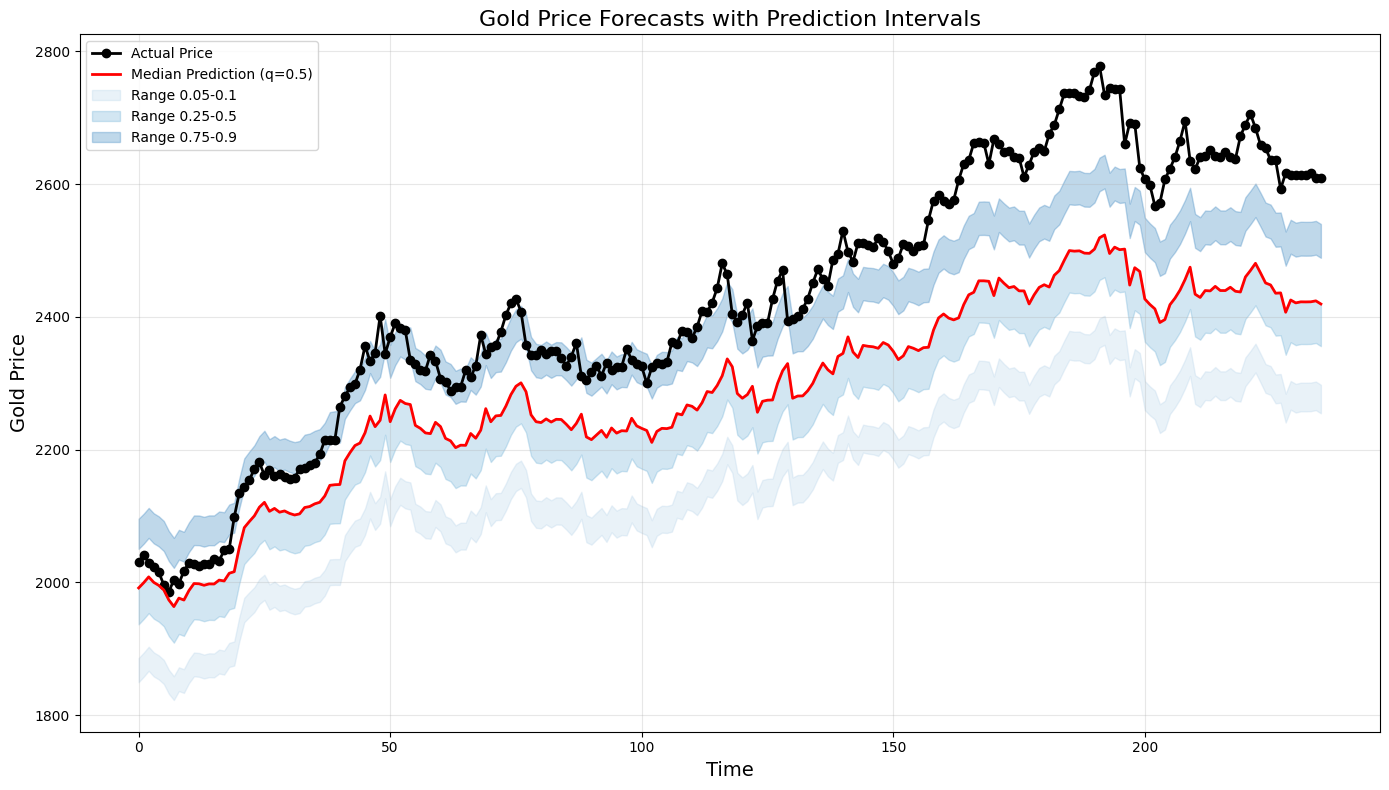

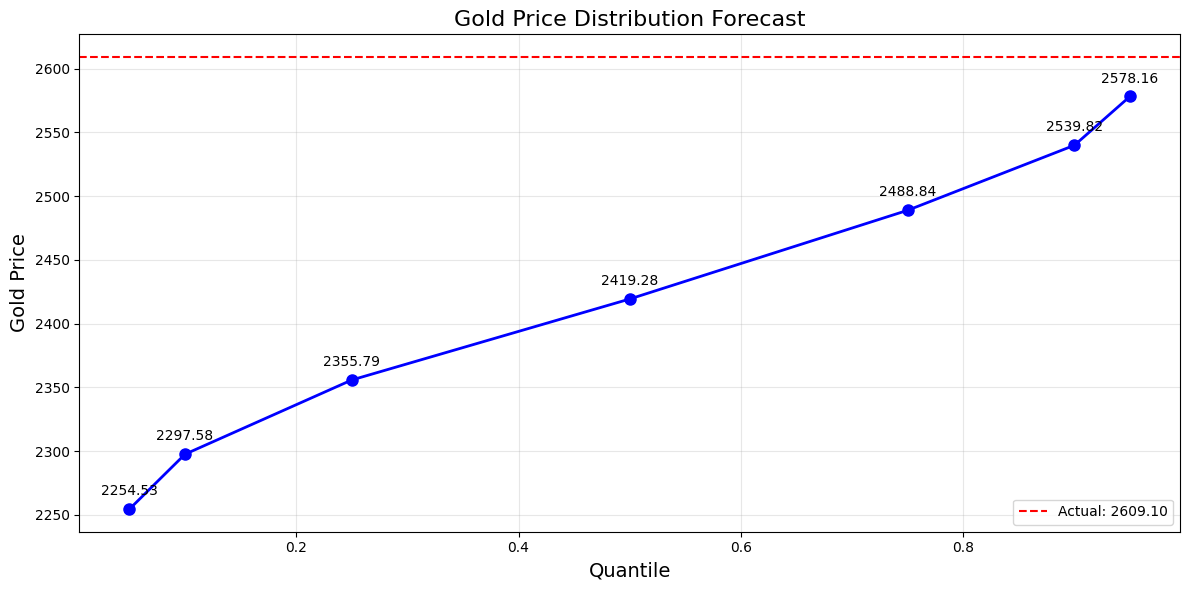

In [24]:
# Load data with your existing function
data = load_data()
features = ["Price","EMA30"]
quantiles = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]

# Run the quantile prediction with custom quantiles if desired
model, results, history = run_quantile_prediction(
    data, 
    features=features,
    quantiles=quantiles,
    seq_length=30
)

# For future predictions with new data
def predict_distribution(model, new_data, scaler, quantiles, target_col=0):
    """
    Generate quantile predictions for new data.
    """
    # Assume new_data is already preprocessed, scaled and in sequence form
    quantile_preds = model.predict(new_data)
    
    # Inverse transform predictions
    quantile_preds_inv = np.zeros((len(quantile_preds), len(quantiles)))
    for i in range(len(quantiles)):
        pred_template = np.zeros((len(quantile_preds), scaler.n_features_in_))
        pred_template[:, target_col] = quantile_preds[:, i]
        quantile_preds_inv[:, i] = scaler.inverse_transform(pred_template)[:, target_col]
    
    return quantile_preds_inv

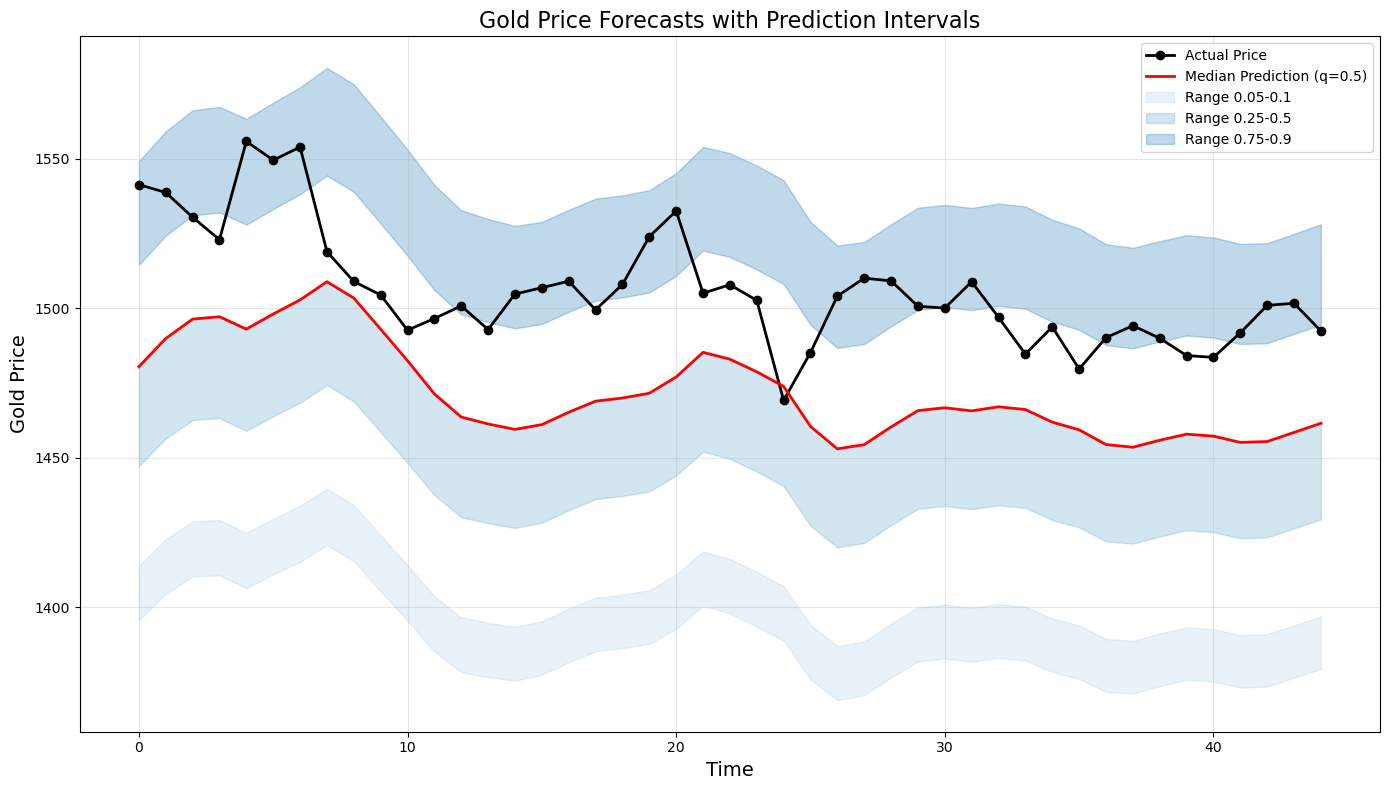

In [13]:
plot_quantile_predictions(results, quantiles, num_days=45)

Epoch 1/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.9025 - val_loss: 0.3356 - learning_rate: 8.0000e-04
Epoch 2/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.3470 - val_loss: 0.2775 - learning_rate: 8.0000e-04
Epoch 3/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2884 - val_loss: 0.2385 - learning_rate: 8.0000e-04
Epoch 4/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.2442 - val_loss: 0.1968 - learning_rate: 8.0000e-04
Epoch 5/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.2156 - val_loss: 0.1726 - learning_rate: 8.0000e-04
Epoch 6/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1950 - val_loss: 0.1875 - learning_rate: 8.0000e-04
Epoch 7/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1803 - val_loss: 0.1315 - learning_rate: 8.0000e-04
Epoch 8/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1706 - val_loss: 0.1350 - learning_rate: 8.0000e-04
Epoch 9/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1592 - val_loss: 

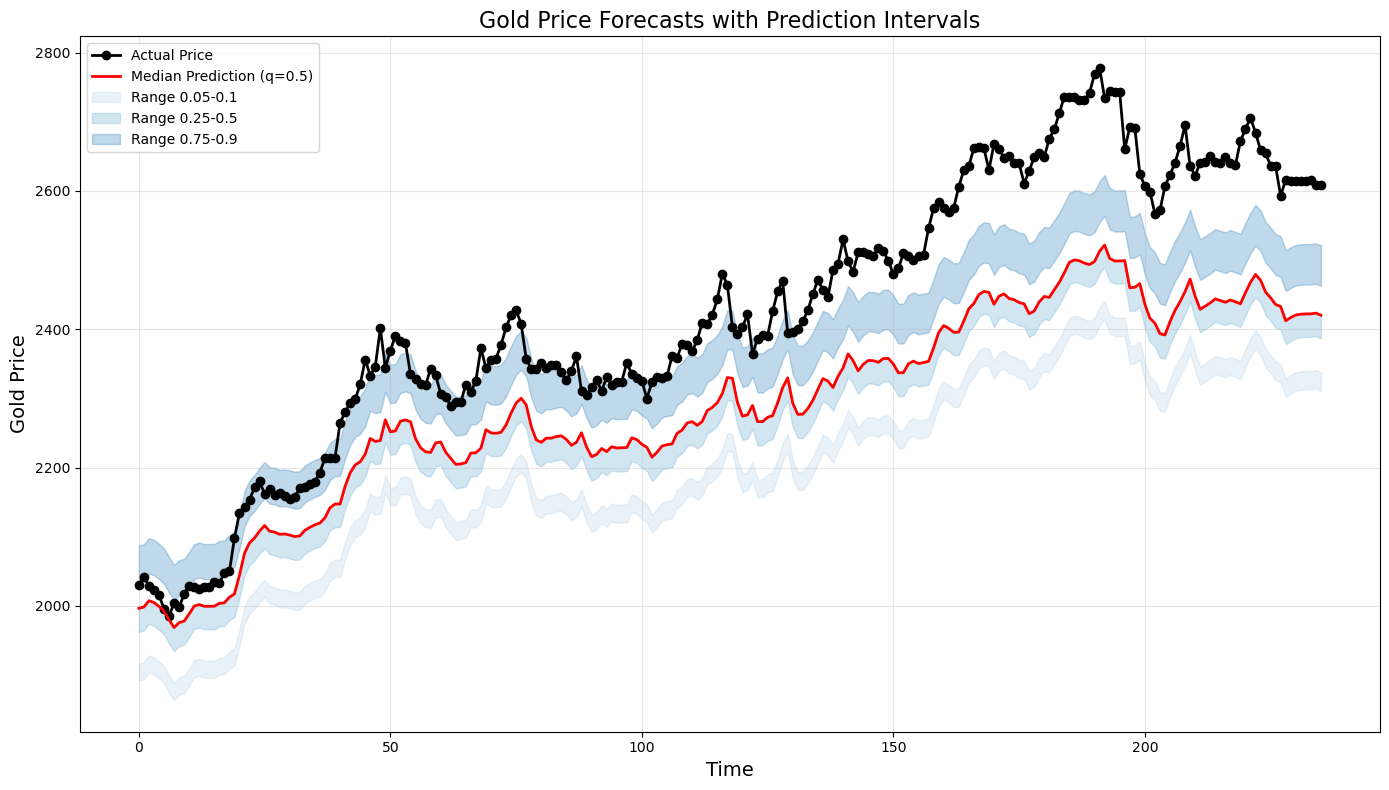

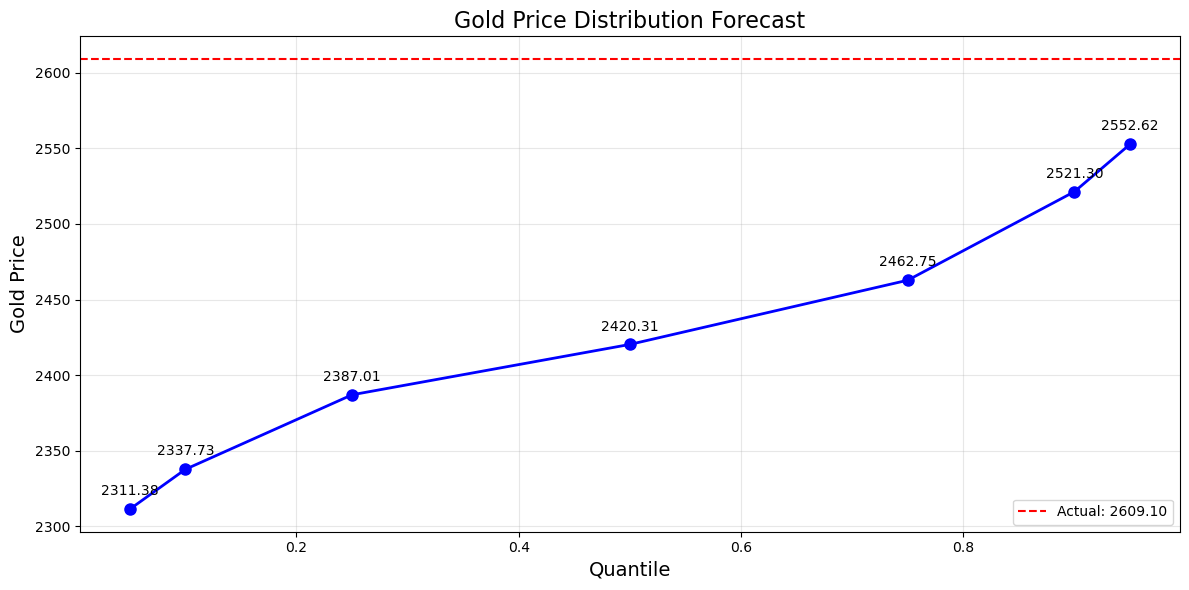

In [18]:
# Load data with your existing function
features = ["Price"]
quantiles = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]

# Run the quantile prediction with custom quantiles if desired
model, results, history = run_quantile_prediction(
    data, 
    features=features,
    quantiles=quantiles,
    seq_length=30
)

In [ ]:
data[-220:]

,Price,DXY,DFII10,VIX,Value,Sentiment_Numeric
Date,,,,,,
2000-01-04,281.5,100.410004,2.43,27.010000,169.8,1.0
2000-01-05,280.5,100.379997,2.43,26.410000,169.8,1.0
2000-01-06,279.4,100.650002,2.43,25.730000,169.8,1.0
2000-01-07,282.1,100.800003,2.43,21.719999,169.8,1.0
2000-01-10,281.6,100.989998,2.43,21.709999,169.8,1.0
2000-01-11,282.3,100.559998,2.43,22.500000,169.8,1.0
2000-01-12,282.3,100.620003,2.43,22.840000,169.8,1.0
2000-01-13,282.1,101.000000,2.43,21.709999,169.8,1.0
2000-01-14,283.3,101.720001,2.43,19.660000,169.8,1.0


<Axes: xlabel='Date'>

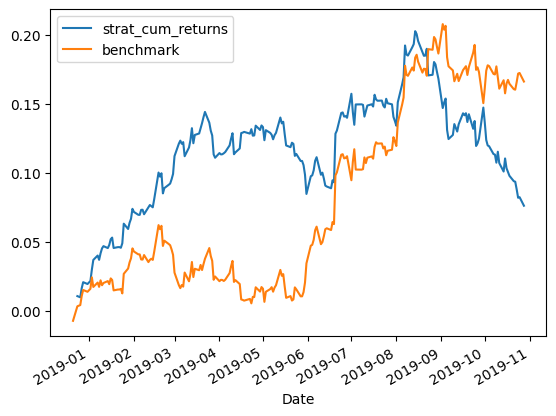

In [ ]:
median_pred = [i[3] for i in results["quantile_preds"]]
df = pd.DataFrame({"median_pred":median_pred, "Price": data[-220:].Price}, index = data[-220:].index)
df["log_returns"] = np.log(df["Price"]/df["Price"].shift(1))
df["pred_log_returns"] = np.log(df["median_pred"]/df["median_pred"].shift(1))
df["pred_pos"] = np.where(df["pred_log_returns"] < 0, -1, 1)
df.dropna(inplace = True)
df["strat_returns"] = df["log_returns"] * df["pred_pos"].shift(1)
df["strat_cum_returns"] = df["strat_returns"].cumsum()
df["benchmark"] = df["log_returns"].cumsum()
df[["strat_cum_returns", "benchmark"]].plot()

# Run

## Model 1

Epoch 1/40
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.2495 - root_mean_squared_error: 0.2840 - val_loss: 0.1922 - val_root_mean_squared_error: 0.3014 - learning_rate: 8.0000e-04
Epoch 2/40
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.1002 - root_mean_squared_error: 0.1082 - val_loss: 0.1325 - val_root_mean_squared_error: 0.2744 - learning_rate: 8.0000e-04
Epoch 3/40
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0617 - root_mean_squared_error: 0.1071 - val_loss: 0.1351 - val_root_mean_squared_error: 0.3190 - learning_rate: 8.0000e-04
Epoch 4/40
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0386 - root_mean_squared_error: 0.0953 - val_loss: 0.1421 - val_root_mean_squared_error: 0.3496 - learning_rate: 8.0000e-04
Epoch 5/40
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0262 - root_mean_squared_error: 0.0921 - val_loss: 0.1202 - val_root_mean_squared_error: 0.3285 - learning_rate: 8.0000e-04
Epoch 6/40
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.01

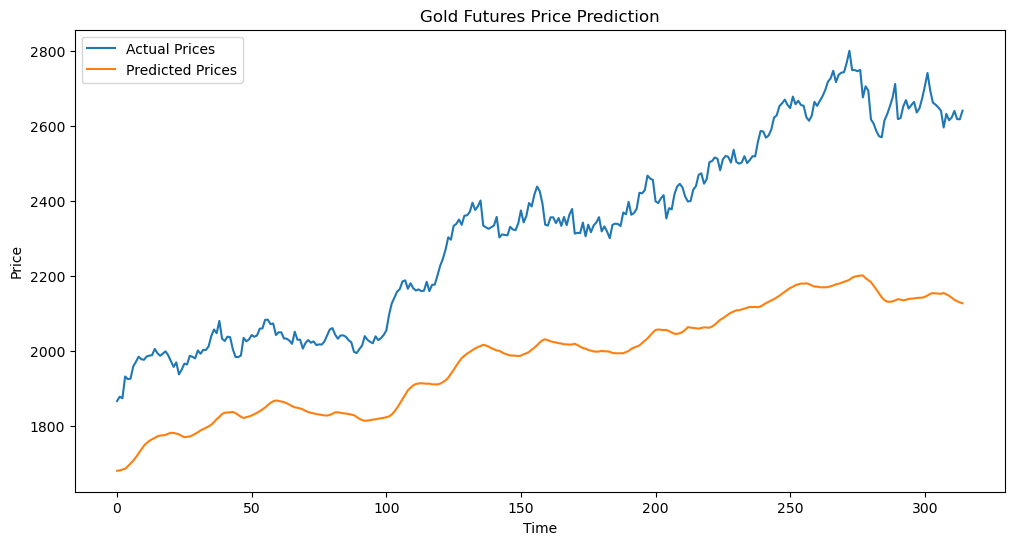

In [40]:
# Load and prepare data
data = load_data()

# Specify which features to use
features = ["Price", "DXY", "VIX", "Sentiment_Numeric", "CPI", "EMA30", "EMA252"]

# Prepare training data
seq_length = 60  # Example sequence length
train_data, test_data, scaler = prepare_training_data(data, seq_length, train_ratio=0.95, features=features)

# Create sequences
target_col = 0  # Index of the target column (Price is the first column)
X_train, y_train = create_sequences(train_data, seq_length, target_col)
X_test, y_test = create_sequences(test_data, seq_length, target_col)

# Build and train model
model = build_model(input_shape=(X_train.shape[1], X_train.shape[2]))
history = train_model(model, X_train, y_train)

# Evaluate model
test_results, mape = evaluate_model(model, X_test, y_test, scaler, target_col)

# Print results
print(f"MAPE: {mape:.2f}%")

# Plot results
plot_results(test_results['actual'], test_results['pred'], title="Gold Futures Price Prediction")

Directional Accuracy: 50.32%


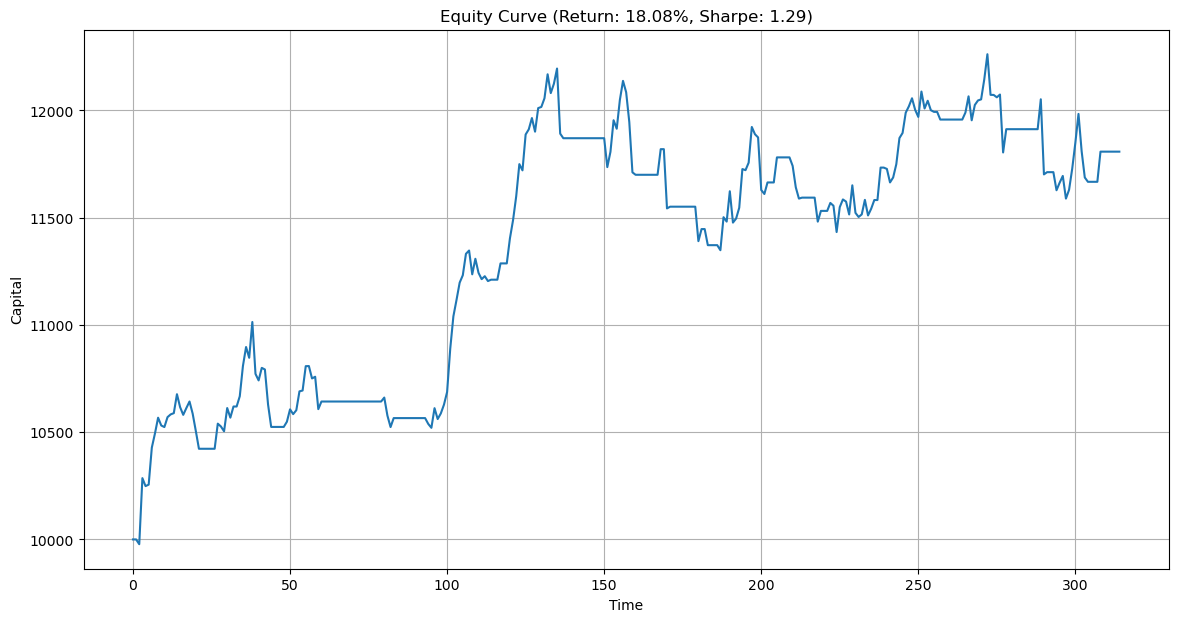

Final capital: $11807.99
Return: 18.08%
Sharpe Ratio: 1.29
Number of trades: 24


In [41]:
def directional_accuracy(y_true, y_pred):
        y_true_changes = np.diff(y_true)
        y_pred_changes = np.diff(y_pred)
        correct_direction = (y_true_changes * y_pred_changes) > 0
        return np.mean(correct_direction) * 100
    
da = directional_accuracy(test_results["actual"], test_results["pred"])
print(f"Directional Accuracy: {da:.2f}%")

# 5. Trading Strategy Backtest
def backtest_trading_strategy(y_true, y_pred, initial_capital=10000):
    """
    Simple backtest of a trading strategy based on predictions
    """
    capital = initial_capital
    position = 0  # 0: no position, 1: long
    trades = []
    equity_curve = [capital]
    
    for i in range(1, len(y_true)):
        # Strategy: Buy if prediction is up, sell if prediction is down
        pred_direction = y_pred[i] > y_pred[i-1]
        
        # Execute trades
        if pred_direction and position == 0:  # Buy signal
            position = 1
            entry_price = y_true[i]
            trades.append(('BUY', i, entry_price))
        elif not pred_direction and position == 1:  # Sell signal
            position = 0
            exit_price = y_true[i]
            profit = exit_price - trades[-1][2]  # Current price - entry price
            capital += profit * (initial_capital / trades[-1][2])  # Scale by position size
            trades.append(('SELL', i, exit_price, profit))
        
        # Update equity curve
        if position == 1:
            # If holding, update equity with unrealized gains/losses
            current_value = capital + (y_true[i] - trades[-1][2]) * (initial_capital / trades[-1][2])
            equity_curve.append(current_value)
        else:
            equity_curve.append(capital)
    
    # Calculate performance metrics
    returns = (capital - initial_capital) / initial_capital * 100
    
    # Calculate Sharpe ratio (simplified)
    daily_returns = np.diff(equity_curve) / np.array(equity_curve[:-1])
    sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)  # Annualized
    
    # Plot equity curve
    plt.figure(figsize=(14, 7))
    plt.plot(equity_curve)
    plt.xlabel('Time')
    plt.ylabel('Capital')
    plt.title(f'Equity Curve (Return: {returns:.2f}%, Sharpe: {sharpe_ratio:.2f})')
    plt.grid(True)
    plt.show()
    
    print(f"Final capital: ${capital:.2f}")
    print(f"Return: {returns:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Number of trades: {len(trades) // 2}")
    
    return trades, equity_curve

trades, equity_curve = backtest_trading_strategy(test_results["actual"], test_results["pred"])

# Hyperparameter Tuning

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression

def select_features(data, target_column="Price", method="random_forest", k=5):
    """
    Selects top k important features.
    
    Parameters:
        data (DataFrame): The input dataset
        target_column (str): Name of the target variable
        method (str): "random_forest"
        k (int): Number of best features to select
        
    Returns:
        DataFrame: Dataset with selected features
    """
    X = data.drop(columns=[target_column]) 
    y = data[target_column]
    
    if method == "random_forest":
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X, y)
        feature_importances = model.feature_importances_
    else:
        raise ValueError("Choose different feature selection method")
    
    selected_features = X.columns[np.argsort(feature_importances)[-k:]]
    
    print(f"Selected Features ({method}): {selected_features.tolist()}")
    
    return data[[target_column] + selected_features.tolist()]


Selected Features (random_forest): ['RSI', 'VIX', 'CPI', 'EMA252', 'EMA30']
Reloading Tuner from keras_tuner_dir/lstm_hyperparams/tuner0.json
Best hyperparameters:
lstm_units_1: 128
lstm_units_2: 96
dense_units: 192
l2_reg: 0.00028950106746006277
dropout_rate: 0.5
learning_rate: 0.002112936764972704
Epoch 1/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.1011 - root_mean_squared_error: 0.2339 - val_loss: 0.0832 - val_root_mean_squared_error: 0.2361 - learning_rate: 0.0021
Epoch 2/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0354 - root_mean_squared_error: 0.1004 - val_loss: 0.0611 - val_root_mean_squared_error: 0.2037 - learning_rate: 0.0021
Epoch 3/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0260 - root_mean_squared_error: 0.0892 - val_loss: 0.0276 - val_root_mean_squared_error: 0.1176 - learning_rate: 0.0021
Epoch 4/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0198 - root_mean_squared_error: 0.0845 - val_loss: 0.0225 - val_root_mean_squared_error

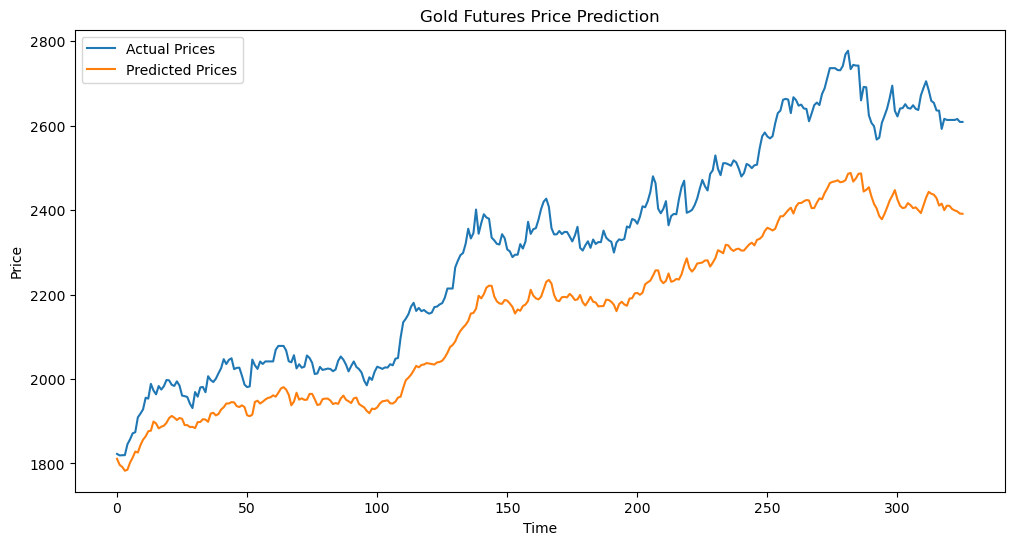

In [23]:
def build_tunable_model(hp, input_shape):
    """
    Build a model with tunable hyperparameters.
    
    Parameters:
        hp: Hyperparameter object from Keras Tuner
        input_shape: Shape of input data
        
    Returns:
        Model: Compiled LSTM model with tunable parameters
    """
    from keras.models import Sequential
    from keras.layers import LSTM, Dense, Dropout, Input
    from keras import regularizers
    from keras.metrics import RootMeanSquaredError
    from keras.optimizers import Adam
    from keras.callbacks import EarlyStopping, ReduceLROnPlateau
    
    model = Sequential()
    model.add(Input(shape=input_shape))
    
    # Tune LSTM units
    lstm_units_1 = hp.Int('lstm_units_1', min_value=32, max_value=128, step=32)
    model.add(LSTM(units=lstm_units_1, return_sequences=True))
    
    lstm_units_2 = hp.Int('lstm_units_2', min_value=32, max_value=128, step=32)
    model.add(LSTM(units=lstm_units_2))

    
    # Tune dense layer units
    dense_units = hp.Int('dense_units', min_value=64, max_value=256, step=64)
    
    # Tune L2 regularization
    l2_reg = hp.Float('l2_reg', min_value=0.0001, max_value=0.01, sampling='log')
    model.add(Dense(dense_units, kernel_regularizer=regularizers.L2(l2_reg)))
    
    # Tune dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.7, step=0.1)
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(units=1))
    
    # Tune learning rate
    learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='log')
    optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, 
                  loss='mean_squared_error', 
                  metrics=[RootMeanSquaredError()])
    #try 
    return model

def tune_hyperparameters(X_train, y_train, input_shape, max_trials=10):
    """
    Perform hyperparameter tuning using Keras Tuner.
    
    Parameters:
        X_train: Training features
        y_train: Training targets
        input_shape: Shape of input data
        max_trials: Maximum number of trials to run
        
    Returns:
        tuple: (best hyperparameters, best model)
    """
    import keras_tuner as kt
    from keras.callbacks import EarlyStopping, ReduceLROnPlateau
    
    # Create a wrapper function to pass input_shape to the model builder
    def model_builder(hp):
        return build_tunable_model(hp, input_shape)
    
    # Define the tuner
    tuner = kt.RandomSearch(
        model_builder,
        objective='val_loss',
        max_trials=max_trials,
        executions_per_trial=1,
        directory='keras_tuner_dir',
        project_name='lstm_hyperparams'
    )
    
    # Alternatively, you can use other tuners:
    # tuner = kt.Hyperband(model_builder, objective='val_loss', max_epochs=30)
    # tuner = kt.BayesianOptimization(model_builder, objective='val_loss')
    
    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    
    # Search for the best hyperparameters
    tuner.search(
        X_train, y_train,
        epochs=40,
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    # Get best hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("Best hyperparameters:")
    for param, value in best_hps.values.items():
        print(f"{param}: {value}")
    
    # Build the model with the best hyperparameters
    best_model = tuner.hypermodel.build(best_hps)
    
    return best_hps, best_model

def train_best_model(best_model, X_train, y_train, epochs=40):
    """
    Train the best model found during hyperparameter tuning.
    
    Parameters:
        best_model: Model with optimal hyperparameters
        X_train: Training features
        y_train: Training targets
        epochs: Number of training epochs
        
    Returns:
        History: Training history
    """
    from keras.callbacks import EarlyStopping, ReduceLROnPlateau
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    
    history = best_model.fit(
        X_train, y_train,
        epochs=epochs,
        verbose=1,
        callbacks=[early_stopping, reduce_lr],
        validation_split=0.2
    )
    
    return history


def hyperparameter_tuning_workflow(data, seq_length, target_column="Price", features=["Price"]):
    """
    Complete workflow for hyperparameter tuning and model training.
    
    Parameters:
        data: Input DataFrame
        seq_length: Length of sequence for LSTM
        features: List of feature columns to use
        
    Returns:
        tuple: (best model, evaluation results)
    """
    data = data[features]
    data_sel = select_features(data, target_column=target_column, k=5)

    # Extract feature names
    selected_features = data_sel.columns.tolist()

    # Prepare data
    train_data, test_data, scaler = prepare_training_data(data, seq_length, features=selected_features)
    
    # Create sequences
    X_train, y_train = create_sequences(train_data, seq_length)
    X_test, y_test = create_sequences(test_data, seq_length)
    
    # Get input shape for the model
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    # Tune hyperparameters
    best_hps, best_model = tune_hyperparameters(X_train, y_train, input_shape)
    
    # Train the best model
    history = train_best_model(best_model, X_train, y_train)
    
    # Evaluate the model
    target_col = features.index("Price") if "Price" in features else 0
    results, mape = evaluate_model(best_model, X_test, y_test, scaler, target_col)
    
    print(f"Mean Absolute Percentage Error: {mape:.2f}%")
    
    # Plot results
    plot_results(results['actual'], results['pred'])
    
    return best_model, results

# Run the hyperparameter tuning workflow
best_model, results = hyperparameter_tuning_workflow(
    data=load_data(), 
    seq_length=30,
    features=["Price", "DXY", "VIX", "Sentiment_Numeric", "CPI", "EMA30", "EMA252", "RSI"] 
)


In [24]:
np.sqrt(np.mean((results["actual"] - results["pred"]) ** 2))

165.6422073912818

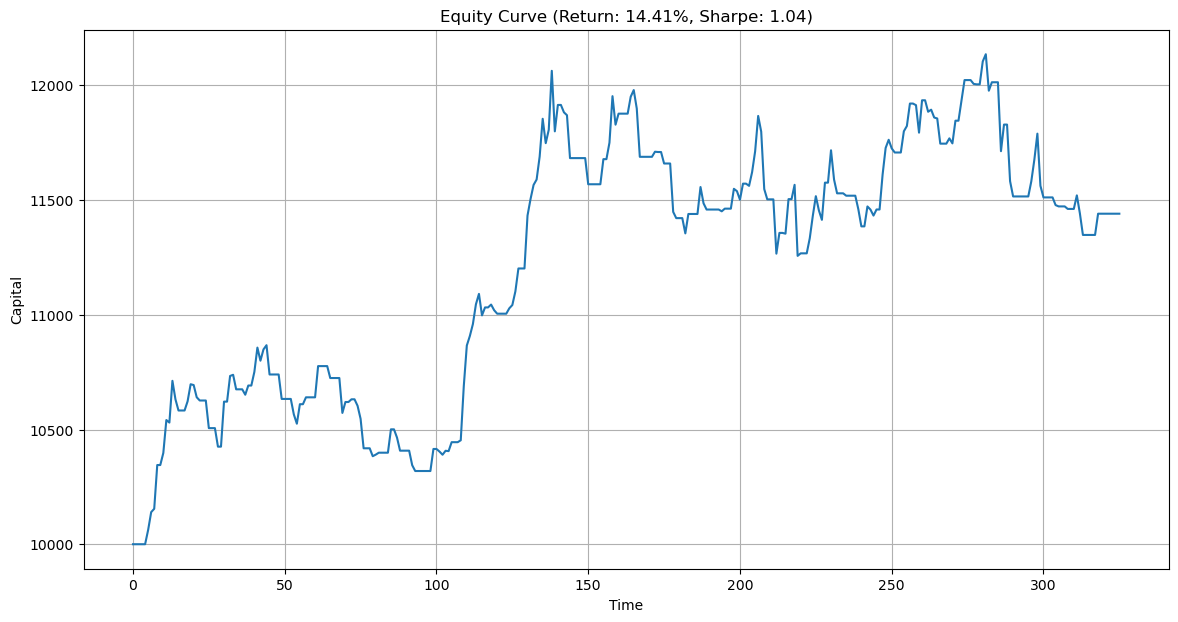

Final capital: $11440.66
Return: 14.41%
Sharpe Ratio: 1.04
Number of trades: 61


In [25]:
trades, equity_curve = backtest_trading_strategy(results["actual"], results["pred"])